# Проект: оценка результатов A/B-теста

Цель проекта: провести оценку результатов A/B-теста recommender_system_test.

Задачи:
- оценить корректность проведения теста;
- изучить пользовательскую активность, построить продуктовую воронку;
- вычислить статистическую разницу в конверсии между группами.

## Описание данных

1. ab_project_marketing_events — календарь маркетинговых событий на 2020 год
- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.
2. final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года
- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.
3. final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. 
4. final_ab_participants — таблица участников тестов.
- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.

ТЗ:
- Название теста: recommender_system_test ;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Ожидаемое количество участников теста: 15% новых пользователей из региона EU;
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики (просмотра товаров, просмотра корзины, покупок) не менее, чем на 5%

## Загрузка данных

In [6]:
#загружаем нужные библиотеки
import pandas as pd
import plotly.express as px
import numpy as np
from datetime import datetime, timedelta
from plotly import graph_objects as go
from scipy import stats as st

In [7]:
#загружаем данные
try:
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    users = pd.read_csv('/datasets/final_ab_new_users.csv')
    events = pd.read_csv('/datasets/final_ab_events.csv')
    participants = pd.read_csv('/datasets/final_ab_participants.csv')

except:
    marketing_events = pd.read_csv('ab_project_marketing_events.csv')
    users = pd.read_csv('final_ab_new_users.csv')
    events = pd.read_csv('final_ab_events.csv')
    participants = pd.read_csv('final_ab_participants.csv')   

In [8]:
# смотрим на датасеты
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [9]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


In [10]:
# смотрим на датасеты
print(users.head())
print(users.info())

            user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None


In [11]:
# смотрим на датасеты
print(events.head())
print(events.info())

            user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457  2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None


In [12]:
# смотрим на датасеты
print(participants.head())
print(participants.info())

            user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  482F14783456D21B     B  recommender_system_test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None


## Предобработка данных

In [13]:
# проверяем на пропуски датасет users
print(users.isna().sum())

# проверяем на дубликаты
print(users.duplicated().sum())

# проверяем на неявные дубликаты
print(users['user_id'].duplicated().sum())

user_id       0
first_date    0
region        0
device        0
dtype: int64
0
0


In [14]:
# проверяем на пропуски датасет events
print(events.isna().sum())

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64


Все пропуски в этом датасете находятся в столбце 'details' (дополнительные данные о событии). Это вспомогательная информация, такие пропуски обрабатывать не нужно.

In [15]:
# посмотрим на уникальные значения в details
events['details'].unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

In [16]:
# выберем строки без пропусков в details
have_details = events[~events['details'].isna()]
have_details.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [17]:
have_details.groupby('event_name').agg({'user_id':'nunique'})

,user_id
event_name,
purchase,19569


Похоже, что столбец details содержит данные о сумме покупки. Соответственно, пропуски есть у пользователей, которые не совершали покупок.

In [18]:
# проверяем на дубликаты
print(events.duplicated().sum())

# проверяем на неявные дубликаты
print(events['user_id'].duplicated().sum())

0
381614


Пользователи могут участвовать в нескольких событиях, отсюда и дубликаты в 'user_id'.

In [19]:
# проверяем на пропуски датасет participants
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [20]:
# проверяем на дубликаты
print(participants.duplicated().sum())

# проверяем на неявные дубликаты
print(participants['user_id'].duplicated().sum())

0
1602


Обнаружились дубликаты в user_id, значит, в датасете есть пользователи, попавшие в обе группы теста.

In [21]:
# сколько пользователей попали в обе группы
doubles=participants.groupby('user_id').agg({'group':'nunique'}).query('group > 1').count()
doubles

group    776
dtype: int64

Есть 776 пользователей, попавших в обе группы. Пока ничего делать не будем, посмотрим, будут ли пользователи, попавшие в обе группы теста, после фильтрации по региону.

In [22]:
# приводим данные к нужному типу
marketing_events['start_dt']=pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt']=pd.to_datetime(marketing_events['finish_dt'])
users['first_date']=pd.to_datetime(users['first_date'])
events['event_dt']=pd.to_datetime(events['event_dt'])

### Оценка корректности проведения теста

In [23]:
# проверяем даты регистрации пользователей
print('Дата начала регистрации пользователей:', users['first_date'].min())
print('Дата окончания регистрации пользователей:',users['first_date'].max())

Дата начала регистрации пользователей: 2020-12-07 00:00:00
Дата окончания регистрации пользователей: 2020-12-23 00:00:00


По заданию дата остановки набора новых пользователей: 2020-12-21, поэтому сразу уберем пользователей, зарегистрировавшихся после этой даты.

In [24]:
users = users.query('first_date <= "2020-12-21" ')
print('Дата окончания регистрации пользователей:',users['first_date'].max())

Дата окончания регистрации пользователей: 2020-12-21 00:00:00


In [25]:
# проверяем, за какой период у нас события (даты теста)
print('Начало теста', events['event_dt'].min())
print('Окончание теста', events['event_dt'].max())

Начало теста 2020-12-07 00:00:33
Окончание теста 2020-12-30 23:36:33


Заявленная дата остановки: 2021-01-04, в датасете не хватает данных за несколько дней (31 декабря-4 января). Возможно, мы имеем дело с проблемой подглядывания: ожидаемое количество данных набралось раньше даты окончания теста, и тест был завершен досрочно. Это увеличивает p-value, и мы сталкиваемся с вероятностю, что при оценке результатов теста критерий покажет значимую разницу, когда ее нет.

In [26]:
# проверяем регион регистрации пользователей
users.groupby('region').agg({'user_id':'nunique'})

,user_id
region,
APAC,2883
CIS,2900
EU,42340
N.America,8347


In [27]:
# объединяем таблицы с пользователями и участниками теста
test_users = pd.merge(users, participants, left_on='user_id', right_on='user_id', how='inner')
test_users.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
2,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
3,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
4,E6DE857AFBDC6102,2020-12-07,EU,PC,B,interface_eu_test


В таблице есть пользователи из двух тестов, изучим из подробнее.

In [28]:
# делаем таблицу с пользователями, попавшими в оба теста
double_users = test_users.groupby('user_id').agg({'group':'nunique'}).query('group > 1').reset_index()
double_users_table = pd.merge(double_users, test_users, left_on='user_id', right_on='user_id', how='inner')
double_users_table.head()

,user_id,group_x,first_date,region,device,group_y,ab_test
0,0082295A41A867B5,2,2020-12-16,EU,iPhone,A,recommender_system_test
1,0082295A41A867B5,2,2020-12-16,EU,iPhone,B,interface_eu_test
2,00E68F103C66C1F7,2,2020-12-18,EU,PC,A,recommender_system_test
3,00E68F103C66C1F7,2,2020-12-18,EU,PC,B,interface_eu_test
4,02313B9E82255F47,2,2020-12-14,EU,Mac,A,recommender_system_test


In [29]:
#сколько % пользователей нашего теста задействованы в конкурирующем
recommender_test_users = test_users.query('ab_test=="recommender_system_test"')
print('Количество пользователей, попавших в оба теста:', len(double_users_table))
print('Процент пользователей нашего теста, задействованных в конкурирующем:', round(len(double_users_table)/len(recommender_test_users)*100,2))

Количество пользователей, попавших в оба теста: 1552
Процент пользователей нашего теста, задействованных в конкурирующем: 23.16


Если мы удалим всех этих пользователей, потеряем 23% участников нашего теста. Посмотрим, в каких группах тестов участвовали "двойники".

In [30]:
double_users_table.groupby(['ab_test', 'group_y']).agg({'user_id':'count'})

user_id
ab_test                 group_y         
interface_eu_test       A            337
                        B            439
recommender_system_test A            439
                        B            337

Пользователи, участвовавшие в конкурирующем тесте в группе А, в нашем тесте попали в группу В, и наоборот. Значит, на группу В в тесте recommender_system_test не повлияло участие в тесте interface_eu_test. Исключать пользователей, участвовавших в двух тестах, не нужно.

In [31]:
# попавшие в тест пользователи из Европы
eu_users = test_users.query('region=="EU" and ab_test=="recommender_system_test"')
# все пользователи из Европы, зарегистрированные в период набора пользователей в тест
all_eu_users = users.query('region=="EU"')
print('Процент пользователей теста из Европы', len(eu_users)/len(all_eu_users)*100)

Процент пользователей теста из Европы 15.0


В тест попали ровно требуемых 15% пользователей из Европы.

In [32]:
# оставляем только участников теста из Европы
test_users = test_users.query('region=="EU"')
recommender_test_users = test_users.query('ab_test=="recommender_system_test"')
# как делятся пользователи на группы внутри теста recommender
recommender_test_users_groups = recommender_test_users.groupby(['group']).agg({'user_id':'nunique'}).reset_index()
recommender_test_users_groups

,group,user_id
0,A,3634
1,B,2717


In [33]:
print('Количество пользователей в тесте:', len(recommender_test_users))

Количество пользователей в тесте: 6351


In [34]:
# есть ли пользователи, попавшие в обе группы теста recommender
recommender_test_users.groupby('user_id').agg({'group':'nunique'}).query('group > 1').count()

group    0
dtype: int64

Пользователей, попавших в обе группы теста recommender_system_test, нет.

#### Динамика набора пользователей в группы

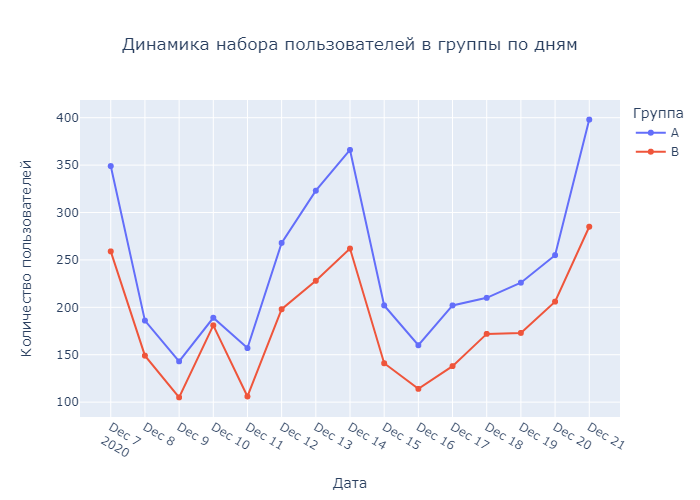

In [65]:
dates_dynamics = recommender_test_users.groupby(['first_date', 'group']).agg({'user_id':'nunique'}).reset_index()

fig = px.line(dates_dynamics, x='first_date', y='user_id', color='group', markers=True,
              title='Динамика набора пользователей в группы по дням')
fig.update_layout(xaxis_title='Дата', yaxis_title='Количество пользователей')
fig.update_layout(legend=dict(title='Группа')) #меняем заголовок легенды
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
fig.update_xaxes(dtick= 86400000.0) # регулируем шаг отметок на оси х
fig.show(renderer='png')

Пользователи набирались равномерно. Был один всплеск набора пользователей в группу В по сравнению с группой А (10 декабря). Также для обеих групп наблюдается всплеск набора 14 и 21 декабря.

In [36]:
# проверяем равномерность распределения пользователей по группам теста
print('Процент пользователей в группе А', round(len(recommender_test_users.query('group=="A"'))/len(recommender_test_users)*100, 2))
print('Процент пользователей в группе В', round(len(recommender_test_users.query('group=="B"'))/len(recommender_test_users)*100, 2))

Процент пользователей в группе А 57.22
Процент пользователей в группе В 42.78


Пользователи по группам распределены не равномерно, причем разница очень большая. Это может исказить результаты теста.

#### Данные о пользовательской активности

In [37]:
# присоединяем таблицу events
test_table = pd.merge(recommender_test_users, events, left_on='user_id', right_on='user_id', how='left')
# сколько пользователей не совершали никаких действий
no_activity = test_table[test_table['event_name'].isna()]
# как эти пользователи распределены по группам теста
no_activity.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
A,1030
B,1840


In [38]:
print('Количество неактивных пользователей:', len(no_activity))
print('Общее количество пользователей теста:', len(recommender_test_users))
print('Процент неактивных пользователей:', round(len(no_activity)/len(recommender_test_users)*100, 2))

Количество неактивных пользователей: 2870
Общее количество пользователей теста: 6351
Процент неактивных пользователей: 45.19


Очень много пользователей остались неактивными, причем большинство из них - в группе В. Посмотрим, как распределяются по группам активные пользователи.

In [39]:
# только пользователи, которые совершали события
test_table_active = pd.merge(recommender_test_users, events, left_on='user_id', right_on='user_id', how='inner')
act = test_table_active.groupby('group').agg({'user_id':'nunique'}).reset_index()
act

,group,user_id
0,A,2604
1,B,877


In [40]:
# процент активных пользователей по группам
act_share = pd.merge(recommender_test_users_groups, act, left_on='group', right_on='group', how='inner')
act_share['active']=round(act_share['user_id_y']/act_share['user_id_x']*100)
act_share

,group,user_id_x,user_id_y,active
0,A,3634,2604,72.0
1,B,2717,877,32.0


Активных участников теста в группе А почти в 3 раза больше, чем в группе В (2604 против 877). Причем активных пользователей в группе В всего 32%, а в группе А - 72%. Мы не можем корректно оценить результаты A/B-теста при таком неравномерном распределении участников. На этом этапе мы оставим неактивных пользователей, но при анализе продуктовой воронки и результатов теста их придется исключить.

In [41]:
# переименовываем столбцы
test_table = test_table.rename(columns={'first_date': 'registration_date', 'event_dt': 'event_date'})
test_table.head()

,user_id,registration_date,region,device,group,ab_test,event_date,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,NaN
2,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test,NaT,NaN,NaN
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:54,product_page,NaN
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08 08:29:31,product_page,NaN


In [42]:
#уберем метки времени из даты событий
test_table['event_date'] = test_table['event_date'].dt.date
test_table['event_date']=pd.to_datetime(test_table['event_date'])

In [43]:
# рассчитаем, на какой день лайфтайма пользователей совершаются события
test_table['event_age'] = (test_table['event_date'] - test_table['registration_date'])/ np.timedelta64(1, 'D') #приводим кол-во дней к типу float
test_table.head()

,user_id,registration_date,region,device,group,ab_test,event_date,event_name,details,event_age
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,product_page,NaN,0.0
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,login,NaN,0.0
2,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test,NaT,NaN,NaN,NaN
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07,product_page,NaN,0.0
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08,product_page,NaN,1.0


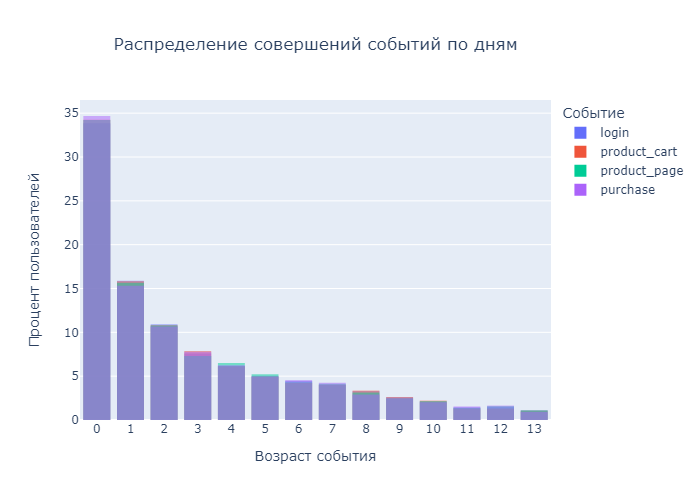

In [66]:
# собираем таблицу для графика
event_age = test_table.groupby(['event_age', 'event_name']).agg({'user_id':'count'}).reset_index() 

# визуализируем
fig = px.histogram(event_age, x='event_age', y='user_id', color='event_name',
                   barmode='overlay', 
                   histnorm='percent', #отображаем процентное соотношение, а не абсолютные значения
                   title='Распределение совершений событий по дням').update_xaxes(categoryorder='trace')

fig.update_layout(xaxis_title='Возраст события', yaxis_title='Процент пользователей')
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
fig.update_xaxes(type='category') # регулируем отметки на оси х
fig.update_layout(legend=dict(title='Событие')) #меняем заголовок легенды
fig.update_xaxes(type='category') # регулируем отметки на оси х
fig.show(renderer='png')

Все события показывают похожий паттерн: большая часть событий происходит в первый день, а уже на второй день число каждого события сокращается вполовину. Со 2 дня количество событий плавно снижается. Уже на шестой день количество пользователей, совершивших событие, составляет 5% или менее от общего количества пользователей этого события. 
Как мы выяснили ранее, заявленная дата остановки теста 2021-01-04, но в датасете представлены данные только до 2020-12-30, поэтому некоторые пользователи могли не успеть "прожить" 14 дней до 30 декабря. Так как обычно большая часть пользователей совершают события в первую неделю после регистрации, нет необходимости убирать тех, кто не успел "прожить" все 14 дней (в датасет уже вошли пользователи, зарегистрированные не позднее 2020-12-21).
Сами же события нужно отфильтровать: нас интересуют только те события, которые произошли в первые 14 дней после регистрации пользователя.

In [45]:
# фильтруем события 
test_table=test_table.query('event_age <= 13 | event_age.isnull()') #включаем пропуски у неактивных пользователей

Посмотрим на возможность получения достоверных результатов АБ-теста, исходя из базового показателя конверсии в 50%, для этого мы воспользуемся онлайн-калькулятором.    

Мы получили следующий результат:  
"Вариант А и В значимо не различаются — конверсия отличается из-за случайных факторов, а не из-за отличий вариантов. Или размер выборки недостаточен для получения статистически значимых результатов". 

Вывод: тест не соответствует требованиям технического задания. 
1. Регистрация пользователей должна заканчиваться 2020-12-21, но в тесте дата окончания регистрации 2020-12-23.
2. Дата остановки теста 2021-01-04, но данные есть только до 2020-12-30. За период 31 декабря-4 января данных нет.
3. 23% участников нашего теста также задействованы в конкурирующем.
4. Участники теста распределены по группам неравномерно: 57.22% в группе А, 42.78% в группе В.
5. Из 6351 пользователей 2870 человек не совершали никаких событий после регистрации, они составляют 45% участников теста.
6. Размер выборки недостаточен для получения достоверных результатов теста (из-за недостаточного количества участников группы В).

Только три требования были выполнены:
1. Есть 15% пользователей из Европы.
2. Участники теста не пересекаются внутри групп А и В.
3. Пользователи в группах набирались равномерно.

## Исследовательский анализ данных

###  Распределение количества событий на пользователя по группам теста

In [46]:
# сколько событий на пользователя в среднем
events_amt = test_table.groupby('group').agg({'user_id':['count', 'nunique']}).reset_index() 
events_amt.columns=['group', 'event_amt', 'user_amt']
events_amt['mean_amt'] = round(events_amt['event_amt']/events_amt['user_amt'])
events_amt

,group,event_amt,user_amt,mean_amt
0,A,18865,3634,5.0
1,B,6625,2717,2.0


In [47]:
# сколько событий на пользователя в среднем среди активных пользователей
events_amt_active = test_table.query('event_age>=0').groupby('group').agg({'user_id':['count', 'nunique']}).reset_index() 
events_amt_active.columns=['group', 'event_amt', 'user_amt']
events_amt_active['mean_amt'] = round(events_amt_active['event_amt']/events_amt_active['user_amt'])
events_amt_active

,group,event_amt,user_amt,mean_amt
0,A,17835,2604,7.0
1,B,4785,877,5.0


В среднем на пользователя в группе А приходится 5 событий, в группе В - 2 события. Среди активных пользователей: 7 в группе А и 5 в группе В.

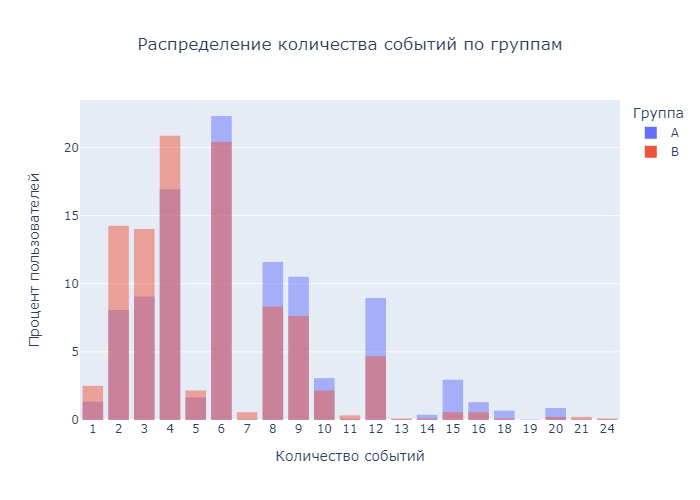

In [67]:
# распределение по количеству событий
events_per_user = test_table.groupby(['group', 'user_id']).agg({'event_name':'count'}).reset_index() 
events_per_user=events_per_user.sort_values(by='event_name', ascending=True)

# визуализируем
fig = px.histogram(events_per_user, x='event_name',  color='group',
                   barmode='overlay', 
                   histnorm='percent', #отображаем процентное соотношение, а не абсолютные значения
                   #histnorm='percent', #отображаем процентное соотношение, а не абсолютные значения
                   title='Распределение количества событий по группам').update_xaxes(categoryorder='trace')

fig.update_layout(xaxis_title='Количество событий', yaxis_title='Процент пользователей')
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
fig.update_xaxes(type='category') # регулируем отметки на оси х
fig.update_layout(legend=dict(title='Группа')) #меняем заголовок легенды
fig.update_xaxes(type='category') # регулируем отметки на оси х
fig.show(renderer='png')

28% пользователей в группе А и 67,7% в группе В не совершали никаких событий. Пользователи в группе А заметно активнее: почти 16% совершили 6 событий, 12% - 4 события. Для группы В эти показатели составляют 6,5% и 6,7% соответственно.

Посмотрим, как выглядит распределение по количеству событий среди активных пользователей.

In [49]:
events_per_user_active = test_table.groupby(['group', 'user_id']).agg({'event_name':'count'}).reset_index() 
events_per_user_active=events_per_user_active.query('event_name>0')
events_per_user_active

,group,user_id,event_name
1,A,0010A1C096941592,12
3,A,00341D8401F0F665,2
5,A,003DF44D7589BBD4,15
6,A,00505E15A9D81546,5
7,A,006E3E4E232CE760,6
...,...,...,...
6333,B,FE76759FE6BF8C68,16
6335,B,FE8F9858BBE502D9,2
6336,B,FEA0C585A53E7027,3
6344,B,FF8CF7057415EB29,4


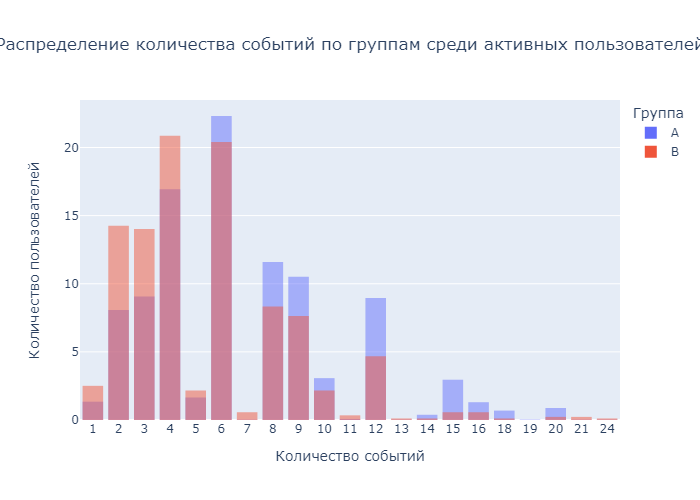

In [68]:
# распределение по количеству событий
events_per_user_active = test_table.groupby(['group', 'user_id']).agg({'event_name':'count'}).reset_index() 
events_per_user_active=events_per_user_active.query('event_name>0')
events_per_user_active=events_per_user_active.sort_values(by='event_name', ascending=True)

# визуализируем
fig = px.histogram(events_per_user_active, x='event_name',  color='group',
                   barmode='overlay', 
                   histnorm='percent', #отображаем процентное соотношение, а не абсолютные значения
                   #histnorm='percent', #отображаем процентное соотношение, а не абсолютные значения
                   title='Распределение количества событий по группам среди активных пользователей').update_xaxes(categoryorder='trace')

fig.update_layout(xaxis_title='Количество событий', yaxis_title='Количество пользователей')
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
fig.update_xaxes(type='category') # регулируем отметки на оси х
fig.update_layout(legend=dict(title='Группа')) #меняем заголовок легенды
fig.update_xaxes(type='category') # регулируем отметки на оси х
fig.show(renderer='png')

Около 22% активных пользователей в группе А совершили 6 событий, почти 17% - 4 события. Среди группы В примерно по 20% совершили 4 или 6 событий, 2 или 3 события - около 14% каждое.

In [51]:
# типы событий
events_amt_per_user = test_table.groupby(['group', 'event_name']).agg({'user_id':['count', 'nunique']}).reset_index() 
events_amt_per_user.columns=['group', 'event_name', 'event_amt', 'user_amt']
events_amt_per_user['mean_amt'] = events_amt_per_user['event_amt']/events_amt_per_user['user_amt']
events_amt_per_user

,group,event_name,event_amt,user_amt,mean_amt
0,A,login,7907,2604,3.036482
1,A,product_cart,2361,782,3.019182
2,A,product_page,5082,1685,3.016024
3,A,purchase,2485,833,2.983193
4,B,login,2310,876,2.636986
5,B,product_cart,617,244,2.528689
6,B,product_page,1240,493,2.515213
7,B,purchase,618,249,2.481928


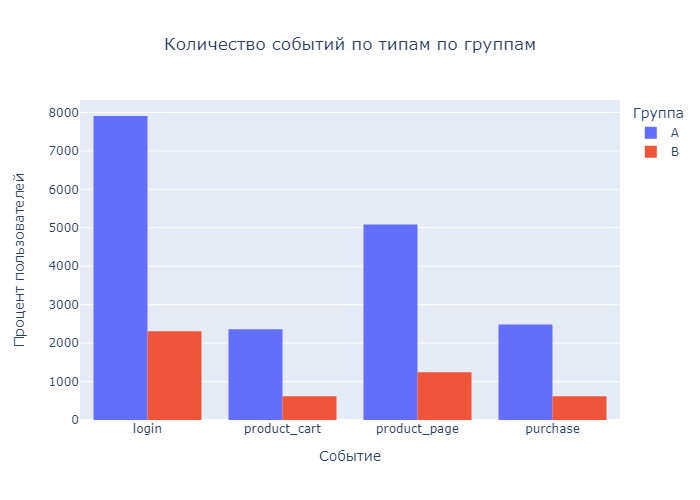

In [69]:
# визуализируем
fig = px.histogram(events_amt_per_user, x='event_name', y='event_amt', color='group',
                   barmode='group', 
                   #histnorm='percent', #отображаем процентное соотношение, а не абсолютные значения
                   title='Количество событий по типам по группам').update_xaxes(categoryorder='trace')

fig.update_layout(xaxis_title='Событие', yaxis_title='Процент пользователей')
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
fig.update_xaxes(type='category') # регулируем отметки на оси х
fig.update_layout(legend=dict(title='Группа')) #меняем заголовок легенды
fig.update_xaxes(type='category') # регулируем отметки на оси х
fig.show(renderer='png')

Самое непопулярное событие в обеих группах - это просмотр корзины. Это связано с тем, что на сайте реализована функция быстрой покупки со страницы товара, и этот шаг проходят не все пользователи. Далее (на этапе воронки) мы посмотрим, какой процент пользователей совершает каждое событие в каждой группе.

### Динамика количества событий в группах теста по дням

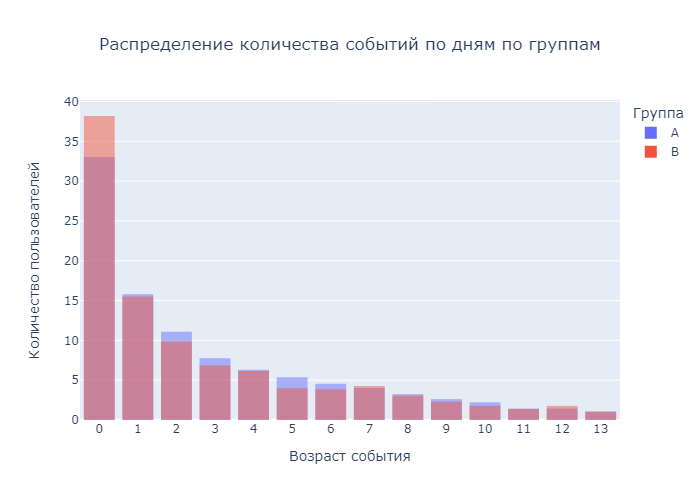

In [70]:
# собираем таблицу для графика
event_day = test_table.groupby(['group','event_age']).agg({'user_id':'count'}).reset_index() 

# визуализируем
fig = px.histogram(event_day, x='event_age', y='user_id', color='group',
                   barmode='overlay', 
                   histnorm='percent', #отображаем процентное соотношение, а не абсолютные значения
                   title='Распределение количества событий по дням по группам').update_xaxes(categoryorder='trace')

fig.update_layout(xaxis_title='Возраст события', yaxis_title='Количество пользователей')
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
fig.update_xaxes(type='category') # регулируем отметки на оси х
fig.update_layout(legend=dict(title='Группа')) #меняем заголовок легенды
fig.update_xaxes(type='category') # регулируем отметки на оси х
fig.show(renderer='png')

В обеих группах большая часть событий происходит в день регистрации. В группе А в день регистрации происходит 33% событий, на следующий - 15,8% событий, далее плавно снижается до 1% на 14 день. В группе В в день регистрации происходит 38% событий, а на следующий день - 15,5%. Есть небольшое колебание по дням: на 6 день лайфтайма совершают события 3,8% пользователей, а на 7 - 4,2%.

Вывод: распределение количества событий между группами различается. В среднем на пользователя в группе А приходится 5 событий, в группе В - 2 события. Среди активных пользователей: 7 в группе А и 5 в группе В. По типам событий также есть небольшая разница: залогинивается в группе В больше пользователей, чем в группе А (47% против 44%), но покупок совершает больше пользователей из группы А (14% против 13%). Динамика по дням практически одинакова в обеих группах: большая часть событий приходится на первый день (33% в группе А и 38% в группе В), резко сокращается на следующий (в обеих группах - примерно до 15%), далее плавно снижается.

### Воздействие маркетинговых событий

In [54]:
# какие маркетинговые события проходили во время проведения теста
start_day = test_table['event_date'].min()
end_day = test_table['event_date'].max()
m_events = marketing_events.query(' @start_day <= finish_dt or start_dt >= @end_day')
m_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Во время проведения теста проходило 2 маркетинговых события: Christmas&New Year Promo и CIS New Year Gift Lottery. Лотерея проходила в другом регионе и участников нашего теста не затронуло. Посмотрим, повлияла ли праздничная промо-акция.

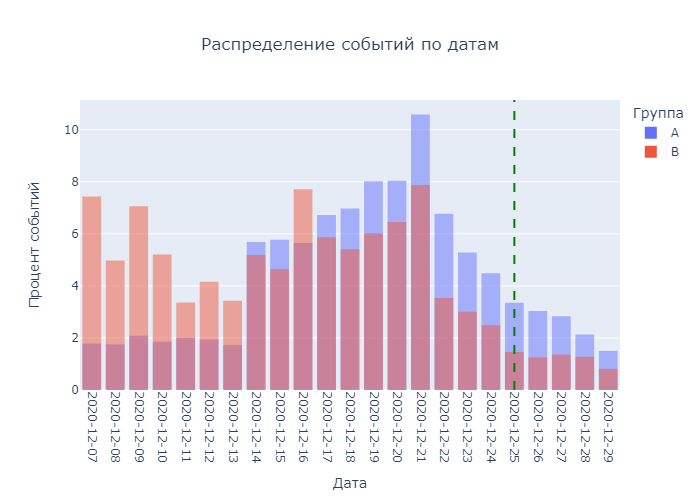

In [71]:
#строим распределение количества событий по дням
test_table['event_day']=test_table['event_date'].dt.date #создаем столбец с датой без метки времени
events_amount = test_table.groupby(['group','event_day']).agg({'event_name':'count'}).reset_index() 

# визуализируем
fig = px.histogram(events_amount, x='event_day', y='event_name', color='group',
                   barmode='overlay', 
                   histnorm='percent', #отображаем процентное соотношение, а не абсолютные значения
                   title='Распределение событий по датам').update_xaxes(categoryorder='trace')

fig.update_layout(xaxis_title='Дата', yaxis_title='Процент событий')
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
fig.update_xaxes(type='category') # регулируем отметки на оси х
fig.update_layout(legend=dict(title='Группа')) #меняем заголовок легенды
fig.update_xaxes(type='category') # регулируем отметки на оси х
fig.update_xaxes(tickangle=90)
date='2020-12-25'
fig.add_vline(x=date, line_dash="dash", line_color="green") #отмечаем линией дату старта акции
fig.show(renderer='png')

Промо-акция не повлияла на количество совершаемых событий: ни в одной из групп не отмечается всплесков активности после начала акции. В группе А наблюдается резкое увеличение событий, начиная с 14 декабря. Возможно, это связано с наплывом новых пользователей. По графику динамики набора пользователей в группы 14 декабря приходится пик набора пользователей в группе А, и, как мы выяснили, большая часть событий происходит в день регистрации и несколько последующих дней.

### Продуктовая воронка

In [56]:
# данные для воронки
group_a = events_amt_per_user.query('group == "A"')
group_b = events_amt_per_user.query('group == "B"')

In [57]:
# задаем порядок воронки для группы А
group_a = group_a.reindex([0,2,1,3])
group_a

,group,event_name,event_amt,user_amt,mean_amt
0,A,login,7907,2604,3.036482
2,A,product_page,5082,1685,3.016024
1,A,product_cart,2361,782,3.019182
3,A,purchase,2485,833,2.983193


In [58]:
# задаем порядок воронки для группы В
group_b = events_amt_per_user.reindex([4,6,5,7])
group_b

,group,event_name,event_amt,user_amt,mean_amt
4,B,login,2310,876,2.636986
6,B,product_page,1240,493,2.515213
5,B,product_cart,617,244,2.528689
7,B,purchase,618,249,2.481928


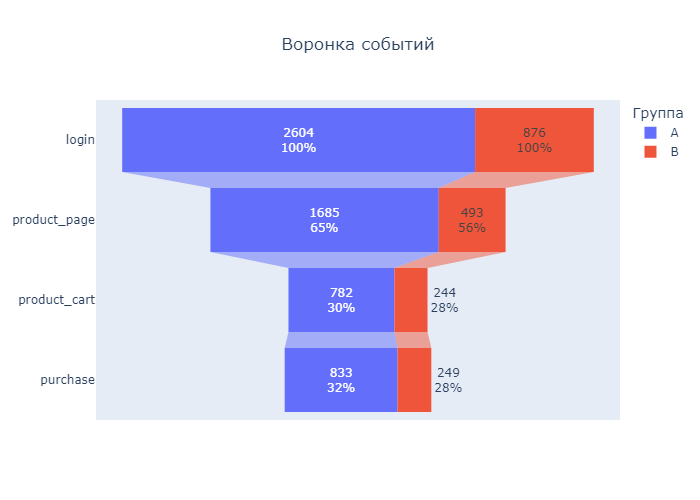

In [72]:
# строим воронку
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = group_a['event_name'],
    x = group_a['user_amt'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    y = group_b['event_name'],
    x = group_b['user_amt'],
    textinfo = "value+percent initial"))
fig.update_layout(title='Воронка событий', title_xref="paper", title_x=0.5) #положение заголовка
fig.update_layout(legend=dict(title='Группа')) #меняем заголовок легенды
fig.show(renderer='png')

Воронка показывает количество пользователей и процент от изначальных (залогиненных) пользователей на каждом шаге. 
- В группе А залогинилось 2604 пользователя, в группе В - всего 876.
- На страницу продукта перешли 65% пользователей в группе А и 56% в группе В.
- В корзину зашли 30% в группе А и 28% в группе В (необязательный шаг).
- Покупку совершили 32%  пользователей в группе А и 28% в группе В.

In [60]:
# разница в конверсии между группами
diff = test_table.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index()
diff['share_A']=diff['A']/2604*100
diff['share_B']=(diff['B']/876)*100
diff['difference']=round(diff['share_B']-diff['share_A'])
diff

group,event_name,A,B,share_A,share_B,difference
0,login,2604,876,100.000000,100.000000,0.0
1,product_cart,782,244,30.030722,27.853881,-2.0
2,product_page,1685,493,64.708141,56.278539,-8.0
3,purchase,833,249,31.989247,28.424658,-4.0


Как мы видим из воронки и таблицы, конверсия в группе В стабильно ниже на каждом шаге, чем в группе А. Ожидаемого эффекта
увеличения конверсии в группе В на 10 процентных пунктов относительно конверсии в группе А не наблюдается.

Вывод: группа В менее активна, чем группа А. 28% пользователей в группе А и 67,7% в группе В не совершали никаких событий. Среди активных пользователей в среднем совершается 7 событий в группе А и 5 в группе В. Конверсия в группе В ниже на 2% на шаге корзины, на 8% на шаге просмотра страницы продукта, на 4% на шаге покупки.

## Оценка результатов A/B-тестирования

Для оценки результатов теста мы проверим статистическую разницу долей z-критерием.  
Нулевая гипотеза: группы равны.  
Альтернативная гипотеза: между группами есть значимая разница.

In [61]:
#исключаем неактивных пользователей
test_table=test_table.query('event_age>=0')
test_table.head()

,user_id,registration_date,region,device,group,ab_test,event_date,event_name,details,event_age,event_day
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,product_page,NaN,0.0,2020-12-07
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,login,NaN,0.0,2020-12-07
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07,product_page,NaN,0.0,2020-12-07
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08,product_page,NaN,1.0,2020-12-08
5,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10,product_page,NaN,3.0,2020-12-10


In [62]:
# таблица с группами, событиями, общим количеством пользователей
funnel_group = (test_table.groupby(['event_name', 'group']).agg({'user_id': 'nunique'}).reset_index().
          rename(columns={'user_id' : 'total_users'}).
          sort_values(by=['group','total_users'], ascending=False))
funnel_group = funnel_group[funnel_group['event_name'] != 'login']
funnel_group

,event_name,group,total_users
5,product_page,B,493
7,purchase,B,249
3,product_cart,B,244
4,product_page,A,1685
6,purchase,A,833
2,product_cart,A,782


In [63]:
# задаем функцию для проверки разницы между группами

def z_test(df1, df2, event, alpha):
    # число пользователей в группе 1 и группе 2:
    n_users = np.array([df1['user_id'].nunique(), 
                        df2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    successes = np.array([df1[df1['event_name'] == event]['user_id'].nunique(), 
                        df2[df2['event_name'] == event]['user_id'].nunique()])
    trials=np.array([df1['user_id'].nunique(), 
                        df2['user_id'].nunique()])
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    print('Событие:', event)
    print('p_value: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')
    

Так как мы проводим множественные сравнения, существует вероятность ошибки первого рода, то есть мы можем ошибочно отвергнуть нулевую гипотезу. Применим метод Шидака для уменьшения FWER.

In [64]:
# применяем функцию
shidok_alpha = 1 - (1 - 0.05)**(1/3) # всего у нас 3 сравнения

for event in funnel_group['event_name'].unique():
    z_test(test_table[test_table['group'] == "A"], test_table[test_table['group'] == "B"], event, shidok_alpha)
    print()

Событие: product_page
p_value:  6.942739359416805e-06
Отвергаем нулевую гипотезу

Событие: purchase
p_value:  0.04652482738393027
Не получилось отвергнуть нулевую гипотезу

Событие: product_cart
p_value:  0.21469192029582396
Не получилось отвергнуть нулевую гипотезу



По результатам теста группы равны на шагах purchase и product_cart, то есть между группами теста нет статистически значимой разницы. Для события product_page нулевая гипотеза была отвергнута, то есть разница между группами есть. Тем не менее, стоит учитывать, что группы для A/B теста различаются по размеру почти в три раза, поэтому результаты теста нельзя считать абсолютно достоверными.

## Выводы

Тестирование было проведено некорректно.   
- Участники теста были распределены по группам неравномерно: 57.22% в группе А, 42.78% в группе В. При этом 45% участников теста неактивны - они не совершили ни одного события после регистрации. По группам разница еще нагляднее: среди участников группы В всего 32% активных пользователей, а среди А - 72%. Размер выборки группы В слишком мал для получения достоверных результатов теста. Также 23% участников нашего теста задействованы в конкурирующем, хотя и в других группах. 
- Данные для теста предоставлены не полностью: нет данных за период 31 декабря-4 января.  

Следующие требования были выполнены: 
- Есть 15% пользователей из Европы.
- Участники теста не пересекаются внутри групп А и В.
- Пользователи в группах набирались равномерно.

Исследовательский анализ показал, что распределение количества событий между группами различается. Среди активных пользователей в среднем совершается 7 событий в группе А и 5 в группе В. Динамика по дням практически одинакова в обеих группах: большая часть событий приходится на первый день (33% в группе А и 38% в группе В), резко сокращается на следующий (в обеих группах - примерно до 15%), далее плавно снижается. Во время проведения теста проходила промо-акция, но она не оказала сильного влияния на участников: ни в одной из групп не отмечается всплесков активности после начала акции. 

Продуктовая воронка по группам выглядит следующим образом:
- В группе А залогинилось 2604 пользователя, в группе В - всего 876.
- На страницу продукта перешли 65% пользователей в группе А и 56% в группе В.
- В корзину зашли 30% в группе А и 28% в группе В (необязательный шаг).
- Покупку совершили 32% пользователей в группе А и 28% в группе В.
Конверсия в группе В ниже на 2% на шаге корзины, на 8% на шаге просмотра страницы продукта, на 4% на шаге покупки. Ожидаемого эффекта увеличения конверсии в группе В на 10% относительно конверсии в группе А нет.

Мы проверили статистическую разницу долей z-критерием. По результатам различий в конверсии между группами на всех шагах, кроме product_page, нет. Однако, учитывая нарушения порядка проведения тестирования, результаты достоверными считать нельзя. Таким образом, мы не можем дать заключение об эффективности внедрения новой рекомендательной системы. Рекомендуется повторить тест, устранив нарушения.